In [1]:
import sys
import logging
import os
import math
import json
from tqdm import tqdm
import warnings
from IPython.display import display, Audio

import librosa
from librosa.feature import mfcc

import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T

from dalle_pytorch import OpenAIDiscreteVAE
from dalle_pytorch.vae import unmap_pixels
from einops import rearrange

import scdata

sys.path.append('..')
logging.getLogger().setLevel(logging.INFO)
warnings.filterwarnings('ignore')

from aural_travels.data import soundcloud
from aural_travels.model import AudioDALLE

# Adjust this to your local copy of the SoundCloud dataset.
# Should contain the `scdata.json` file and the `audio` directory.
MODEL_DIR = '/home/leo/src/aural-travels/models/poc_valid_toy'

In [2]:
with open(os.path.join(MODEL_DIR, 'params.json')) as f:
    params = json.load(f)

In [3]:
params

{'soundcloud_data_dir': '/home/leo/src/scdata',
 'dataset': 'soundcloud',
 'num_workers': 64,
 'batch_size': 8,
 'gradient_accumulation': 1,
 'num_epochs': 500,
 'hidden_size': 256,
 'num_layers': 8,
 'num_heads': 256,
 'attention_dropout': 0.1,
 'ffnn_dropout': 0.01,
 'lr': 0.001,
 'output_dir': 'models/poc_valid_toy',
 'sample_secs': 2.0,
 'n_fft': 2048,
 'hop_length': 1024,
 'save_steps': 50,
 'eval_steps': 50,
 'encoding_dir': 'models/encoding',
 'seed': 42,
 'toy_data': True}

In [4]:
vae = OpenAIDiscreteVAE()
vae.eval()

split = 'training'
#split = 'validation'
dataset = soundcloud.CoverGenerationDataset(data_dir=params['soundcloud_data_dir'],
                                            split='training',
                                            image_labels=torch.load(f'../models/encoding/{split}.pt'),
                                            sample_secs=params['sample_secs'],
                                            n_fft=params['n_fft'],
                                            hop_length=params['hop_length'])
model = AudioDALLE(vae=vae,
                   audio_seq_len=dataset.num_samples(),
                   audio_num_features=dataset.num_features(),
                   hidden_size=params['hidden_size'],
                   num_layers=params['num_layers'],
                   num_heads=params['num_heads'],
                   attention_dropout=params['attention_dropout'],
                   ffnn_dropout=params['ffnn_dropout'])
model.eval().to('cuda')

AudioDALLE(
  (vae): OpenAIDiscreteVAE(
    (enc): Encoder(
      (blocks): Sequential(
        (input): Conv2d(n_in=3, n_out=256, kw=7, use_float16=True, device=device(type='cpu'), requires_grad=False)
        (group_1): Sequential(
          (block_1): EncoderBlock(
            (id_path): Identity()
            (res_path): Sequential(
              (relu_1): ReLU()
              (conv_1): Conv2d(n_in=256, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
              (relu_2): ReLU()
              (conv_2): Conv2d(n_in=64, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
              (relu_3): ReLU()
              (conv_3): Conv2d(n_in=64, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
              (relu_4): ReLU()
              (conv_4): Conv2d(n_in=64, n_out=256, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
            )
          )
          (block_2): 

In [5]:
checkpoint = torch.load(os.path.join(MODEL_DIR, 'last_checkpoint.pt'))
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [6]:
checkpoint['global_step']

1000

  0%|          | 0/10 [00:00<?, ?it/s]

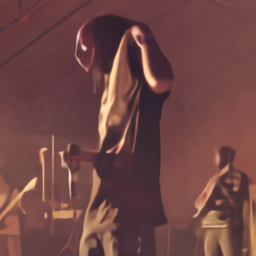

 10%|█         | 1/10 [00:01<00:13,  1.51s/it]

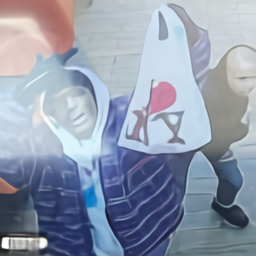

 20%|██        | 2/10 [00:02<00:09,  1.15s/it]

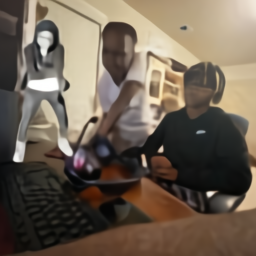

 30%|███       | 3/10 [00:03<00:07,  1.02s/it]

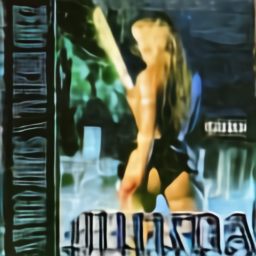

 40%|████      | 4/10 [00:04<00:05,  1.05it/s]

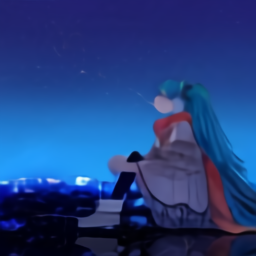

 50%|█████     | 5/10 [00:04<00:04,  1.09it/s]

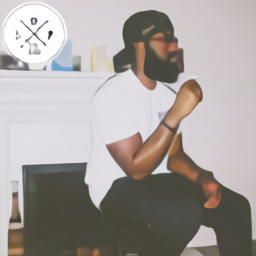

 60%|██████    | 6/10 [00:05<00:03,  1.10it/s]

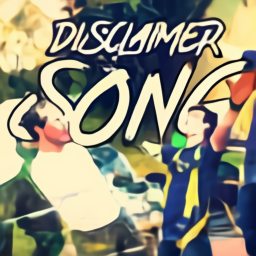

 70%|███████   | 7/10 [00:06<00:02,  1.15it/s]

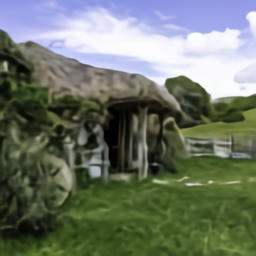

 80%|████████  | 8/10 [00:07<00:01,  1.18it/s]

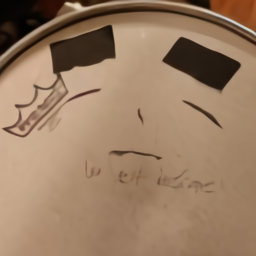

 90%|█████████ | 9/10 [00:08<00:00,  1.18it/s]

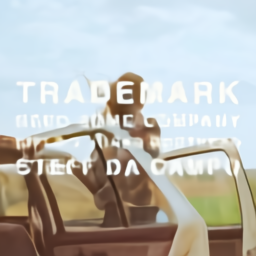

100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


In [7]:
indices = list(range(10))

audios = []
image_seq_refs = []
for idx in tqdm(indices):
    track = dataset.tracks[idx]
    example = dataset[idx]
    audios.append(example[0][None, :, :])
    image_seq_refs.append(example[1])
    
    display(T.ToPILImage(mode='RGB')(model.vae.decode(example[1][None, :].to('cuda'))[0]))

Dancehall: Keros-n - Viv li (74261447)


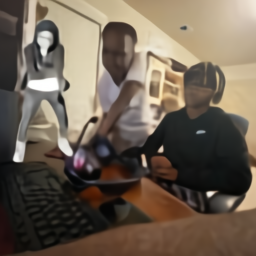

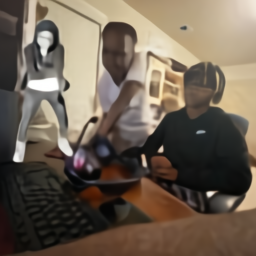

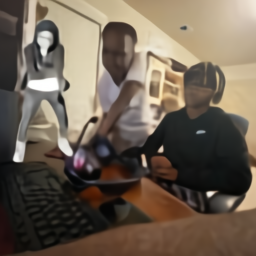

TRAP: MONEY JUMP LIKE JORDAN (742354414)


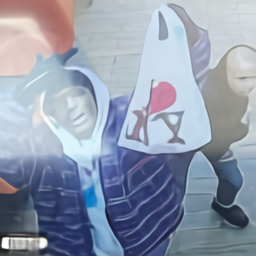

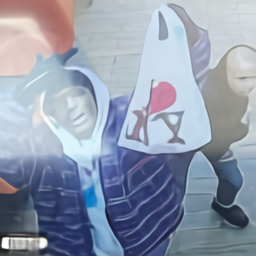

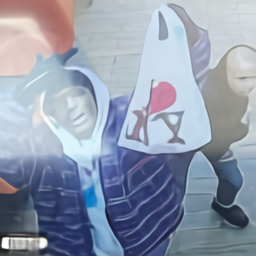

Hip-hop & Rap: dynamic slatt$$$ (donkey fart,gtb tezz,davi) (742426864)


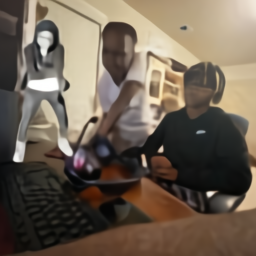

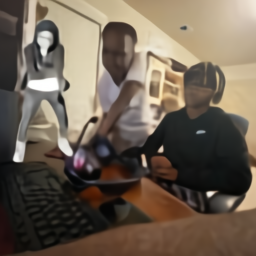

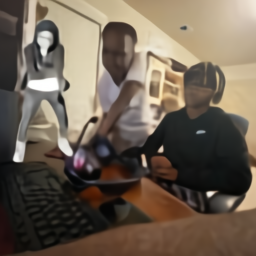

Hip-hop & Rap: MURDA ft $KRRT COBAIN (Prod Bleak) (742409980)


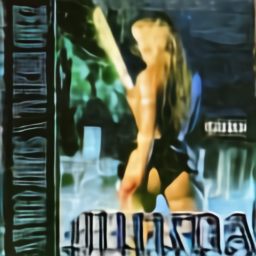

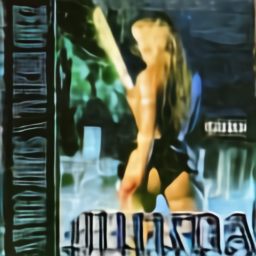

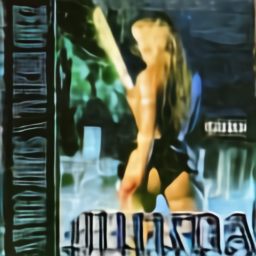

Nightcore: Nightcore - Last Night (74243874)


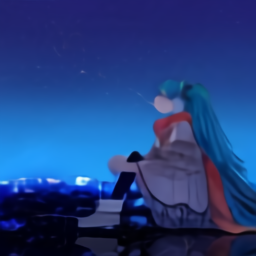

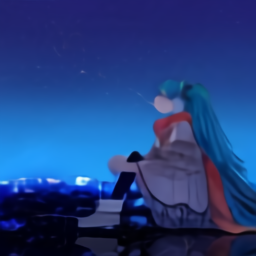

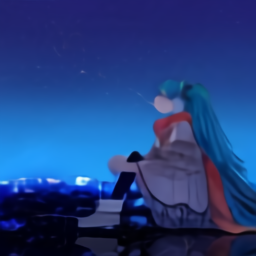

Hip-hop & Rap: Marathon (742414540)


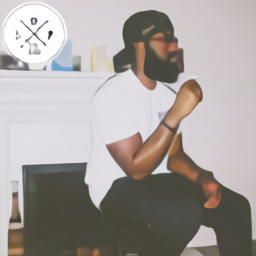

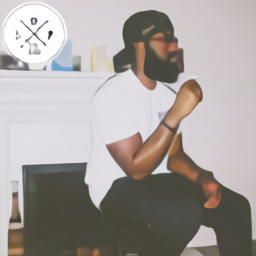

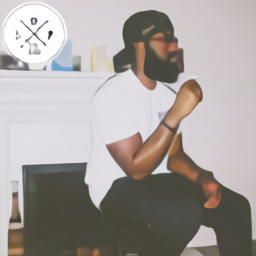

Jazz & Blues: Disclaimer Song (742482604)


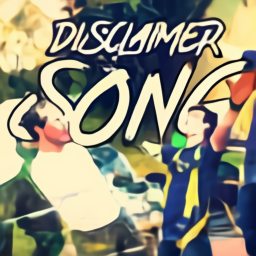

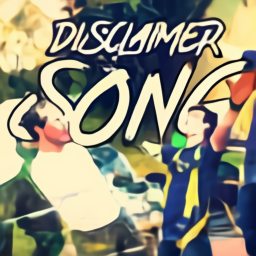

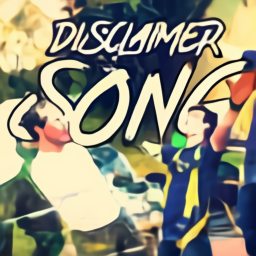

Trap: Followers (Creative Commons) FREE hip hop beat (742686925)


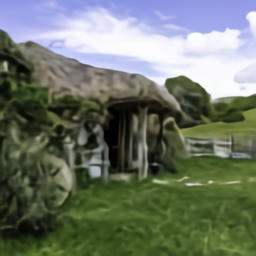

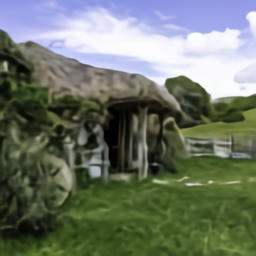

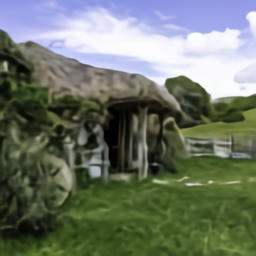

Rock: i'm not incelcore (willow cover) (742035211)


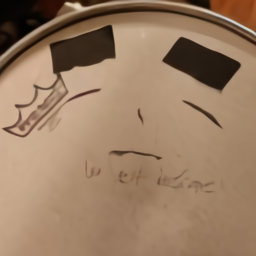

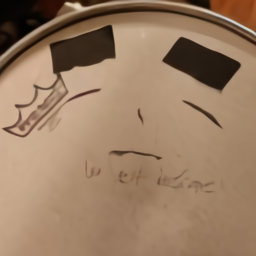

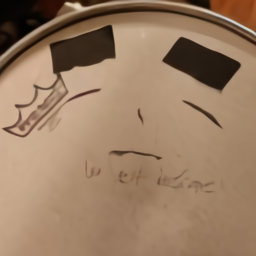

Dance & EDM: Need Some Company (Diplo X Jonas Brothers X Steff Da Campo) (742556362)


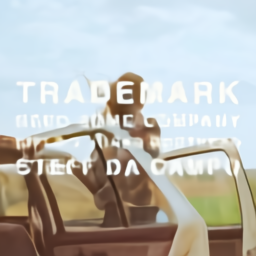

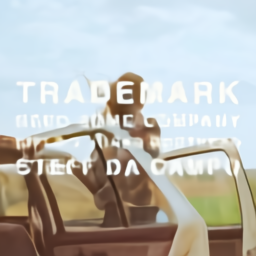

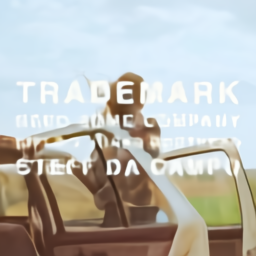

In [9]:
save_to = os.path.join(MODEL_DIR, 'gen_step1000_temp0.5')
os.makedirs(save_to, exist_ok=True)

for idx, audio in zip(indices, audios):
    track = dataset.tracks[idx]
    print(f'{track["genre"]}: {track["title"]} ({track["id"]})')
    
    for i in range(3):
        image_seq = model.generate_images(audio.to('cuda'), temperature=0.5)
        image = T.ToPILImage(mode='RGB')(model.vae.decode(image_seq)[0])
        image.save(os.path.join(save_to, f'{idx}_{i}.png'))
        display(image)

In [ ]:
track = dataset.tracks[1]
audio_path = scdata.get_audio_path(os.path.join(dataset.data_dir, 'audio'), track['id'])
Audio(audio_path)

In [24]:
def vae_decode_interpolated(vae, image_seq1, image_seq2, t):
    # As <https://github.com/lucidrains/DALLE-pytorch/blob/bdb04280c9ab55eb20f86b375dc1aad20fbd5315/dalle_pytorch/vae.py#L116>,
    # but interpolating the embeddings
    b, n = image_seq1.shape
    image_seq1 = rearrange(image_seq1, 'b (h w) -> b h w', h = int(math.sqrt(n)))
    image_seq2 = rearrange(image_seq2, 'b (h w) -> b h w', h = int(math.sqrt(n)))
    
    z1 = F.one_hot(image_seq1, num_classes=vae.num_tokens)
    z2 = F.one_hot(image_seq2, num_classes=vae.num_tokens)
    z1 = rearrange(z1, 'b h w c -> b c h w').float()
    z2 = rearrange(z2, 'b h w c -> b c h w').float()
    
    n_interp = 4
    modules = list(vae.dec.blocks)
    
    for module in modules[:n_interp]:
        z1 = module(z1)
        z2 = module(z2)
        
    print(f'z1 norm: {z1.size()}')

    x = z1 * (1.0 - t) + z2 * t
    
    for module in modules[n_interp:]:
        x = module(x)
    
    return unmap_pixels(torch.sigmoid(x[:, :3]))

In [ ]:
frames_dir = os.path.join(MODEL_DIR, 'frames_interpolated2') 
os.makedirs(frames_dir, exist_ok=True)

keyframe_secs = 0.5
keyframe_hop = int(keyframe_secs * dataset.num_samples() / dataset.sample_secs)

y, _ = librosa.load(audio_path,
                    sr=dataset.sample_rate,
                    mono=True)
mel = mfcc(y=y,
           sr=dataset.sample_rate,
           n_fft=dataset.n_fft,
           hop_length=dataset.hop_length,
           center=False)
mel = torch.tensor(mel, dtype=torch.float).T
mel = (mel - dataset.mfcc_mean) * dataset.mfcc_std_inv

last_image = None
frame_idx = 0

keyframes = []

for i in range(mel.size()[0] // keyframe_hop):
    audio = mel[None, i*keyframe_hop:i*keyframe_hop+dataset.num_samples(), :]
    audio = audio.to('cuda')
    #image = torch.zeros((1, 32*32), dtype=torch.long, device='cuda')
    image = model.generate_images(audio)
    
    if last_image is not None:
        samples = 10
        for j in range(samples):
            between_image = vae_decode_interpolated(model.vae, last_image, image, j/samples)[0]
            pil_image = T.ToPILImage(mode='RGB')(between_image)
            display(pil_image)
            pil_image.save(os.path.join(frames_dir, f'{frame_idx}.png'))
            frame_idx += 1
    
    print(i)
    pil_image = T.ToPILImage(mode='RGB')(model.vae.decode(image)[0])
    display(pil_image)
    pil_image.save(os.path.join(frames_dir, f'{frame_idx}.png'))
    frame_idx += 1
    
    keyframes.append(image)
    last_image = image

In [26]:
keyframes

[tensor([[3244, 6954, 1038,  ...,   54, 3693, 4841]], device='cuda:0'),
 tensor([[2901, 1969, 6619,  ..., 3071, 2901, 2736]], device='cuda:0'),
 tensor([[2343, 6384, 6384,  ..., 7451, 2329, 7419]], device='cuda:0')]

In [29]:
torch.sum(keyframes[1] == keyframes[2])

tensor(1, device='cuda:0')